In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd 
from keras.layers import Input, Lambda, Dense, Flatten , Dropout , MaxPool2D
from keras.models import Model , Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
import random
import os
from distutils.file_util import copy_file
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau

# Data Preparation

In [2]:
covidDataPath='../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID'
pneumoniaDataPath='../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia'
normalDataPath='../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

In [3]:
# Lists for access paths
listCovidPaths = []
listNormalPaths = []

# Get covid images files paths
for root, directories, files in os.walk(covidDataPath):
    for name in files:
        listCovidPaths.append(os.path.join(root, name))

# for root, directories, files in os.walk(pneumoniaDataPath):
#     for name in files:
#         listCovidPaths.append(os.path.join(root, name))        
        
# Get normal images files paths
for root, directories, files in os.walk(normalDataPath):
    for name in files:
        listNormalPaths.append(os.path.join(root, name))

# Shuffle lists for random train / test

random.shuffle(listCovidPaths)
random.shuffle(listNormalPaths)

In [4]:
len(listCovidPaths)

3616

In [5]:
len(listNormalPaths)

10192

In [6]:
# main folder
!mkdir ./Data/

# Train data folders
!mkdir ./Data/Train/
!mkdir ./Data/Train/Covid/
!mkdir ./Data/Train/Normal/

# Test data folders
!mkdir ./Data/Test/
!mkdir ./Data/Test/Covid/
!mkdir ./Data/Test/Normal/

# Valid data folders
!mkdir ./Data/Valid/
!mkdir ./Data/Valid/Covid/
!mkdir ./Data/Valid/Normal/

# Paths to covid images folders
pathCovidTrain = './Data/Train/Covid/'
pathCovidTest = './Data/Test/Covid/'
pathCovidValid='./Data/Valid/Covid/'


# Paths to normal images folders
pathNormalTrain = './Data/Train/Normal/'
pathNormalTest = './Data/Test/Normal/'
pathNormalValid='./Data/Valid/Normal/'


In [7]:
"""
Moving files to new folders
"""

# Move covid images files to new folders
for i in range(3616):
    if i < 2893:
        copy_file(listCovidPaths[i], pathCovidTrain)
    elif i>=2893 and i<=3255:
        copy_file(listCovidPaths[i], pathCovidValid)
    else  : 
        copy_file(listCovidPaths[i], pathCovidTest)
        
for i in range(10192):
    if i < 8154:
        copy_file(listNormalPaths[i], pathNormalTrain)
    elif i>=8154 and i<=9174:
        copy_file(listNormalPaths[i], pathNormalValid)     
    else  : 
        copy_file(listNormalPaths[i], pathNormalTest)       

# Data Augmentation

In [8]:

train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

train = train_data_gen.flow_from_directory(directory= './Data/Train',
                                           class_mode = 'binary',
                                           batch_size=64,
                                           target_size=(224,224))

Found 11047 images belonging to 2 classes.


In [9]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= './Data/Test' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

valid = test_data_gen.flow_from_directory(directory= './Data/Valid' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

Found 1377 images belonging to 2 classes.
Found 1384 images belonging to 2 classes.


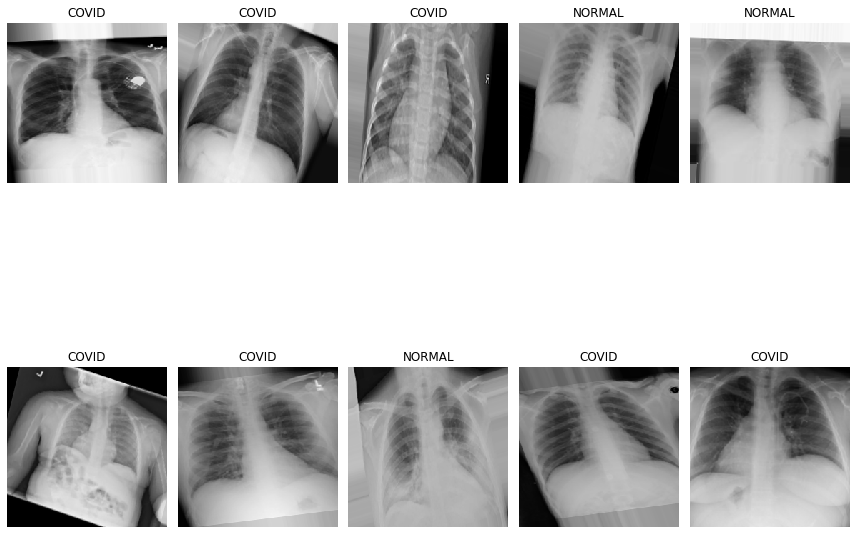

In [10]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'COVID'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Importing ResNet V2

In [11]:
inc = tf.keras.applications.InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
    classifier_activation = 'sigmoid'
)

219062272/219055592 [==============================] - 7s 0us/step


In [12]:
for layer in inc.layers:           
  layer.trainable = False

In [13]:
'''
Definition of the Keras model outputs
'''

x = Flatten()(inc.output)
prediction= Dense(units=1 , activation='sigmoid')(x)

model = Model(inc.input,prediction)

In [14]:
"""
Compile model
"""

model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [16]:
early = EarlyStopping(monitor='val_accuracy', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [17]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9092637400622192, 1: 0.6773975962717684}


In [18]:
hist = model.fit(train, steps_per_epoch= len(train), epochs= 15, validation_data= valid,class_weight=cw,validation_steps= len(test), callbacks=callbacks_list)

Epoch 1/15
173/173 [==============================] - 173s 923ms/step - loss: 1.3588 - accuracy: 0.7368 - val_loss: 0.3325 - val_accuracy: 0.8699
Epoch 2/15
173/173 [==============================] - 158s 913ms/step - loss: 0.4570 - accuracy: 0.8430 - val_loss: 0.3797 - val_accuracy: 0.9090
Epoch 3/15
173/173 [==============================] - 153s 887ms/step - loss: 0.5643 - accuracy: 0.8467 - val_loss: 0.2965 - val_accuracy: 0.9184
Epoch 4/15
173/173 [==============================] - 155s 896ms/step - loss: 0.4435 - accuracy: 0.8644 - val_loss: 0.3051 - val_accuracy: 0.8952



# Results

<AxesSubplot:>

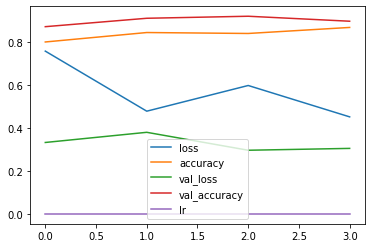

In [19]:
pd.DataFrame(hist.history).plot()

In [20]:
import seaborn as sns

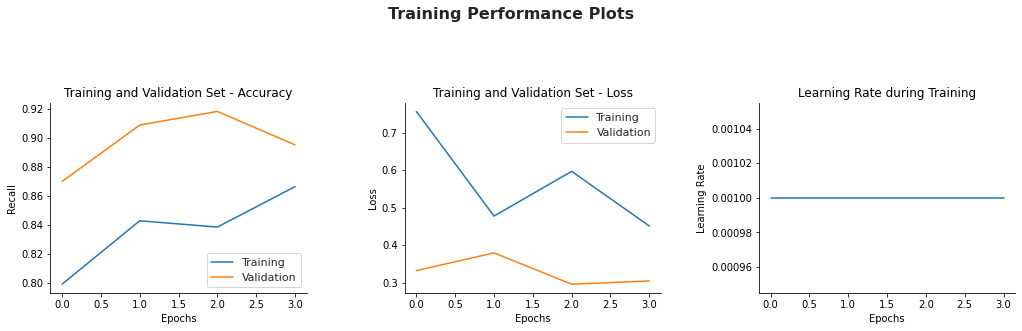

In [21]:

#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(hist.history)

ax = sns.lineplot(x =historyDF.index, y = hist.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x =historyDF.index, y = hist.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = hist.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = hist.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [22]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

22/22 [==============================] - 7s 295ms/step - loss: 0.3247 - accuracy: 0.8889
The testing accuracy is : 88.88888955116272 %


In [23]:
preds = model.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

22/22 [==============================] - 9s 280ms/step


## Confusion Matrix

<AxesSubplot:>

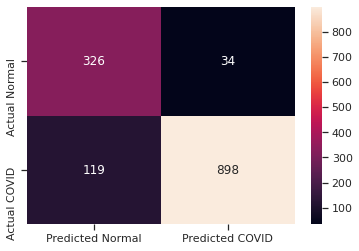

In [24]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual COVID"],
columns=["Predicted Normal", "Predicted COVID"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [25]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','COVID']))

              precision    recall  f1-score   support

      NORMAL       0.73      0.91      0.81       360
       COVID       0.96      0.88      0.92      1017

    accuracy                           0.89      1377
   macro avg       0.85      0.89      0.87      1377
weighted avg       0.90      0.89      0.89      1377



In [26]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(1377, 224, 224, 3)
(1377,)


In [27]:
y_true=test.classes

In [28]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


**Overall Results**
Accuracy Result: 88.89%
Precision Result: 96.35%
Recall Result: 88.30%
F-Score Result: 92.15%


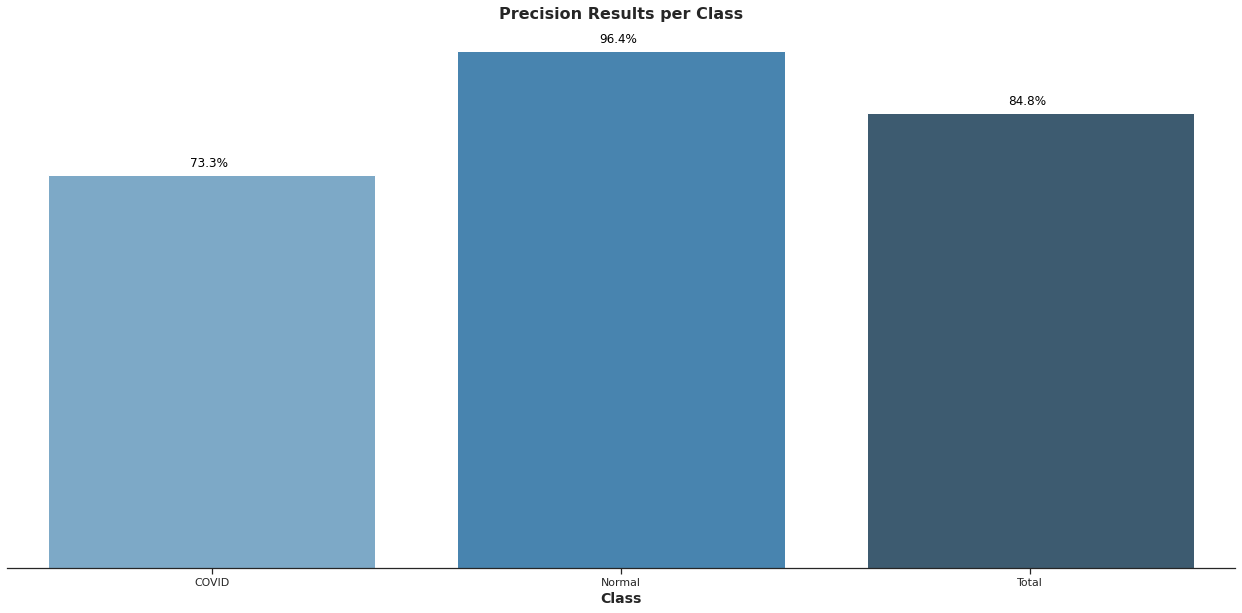

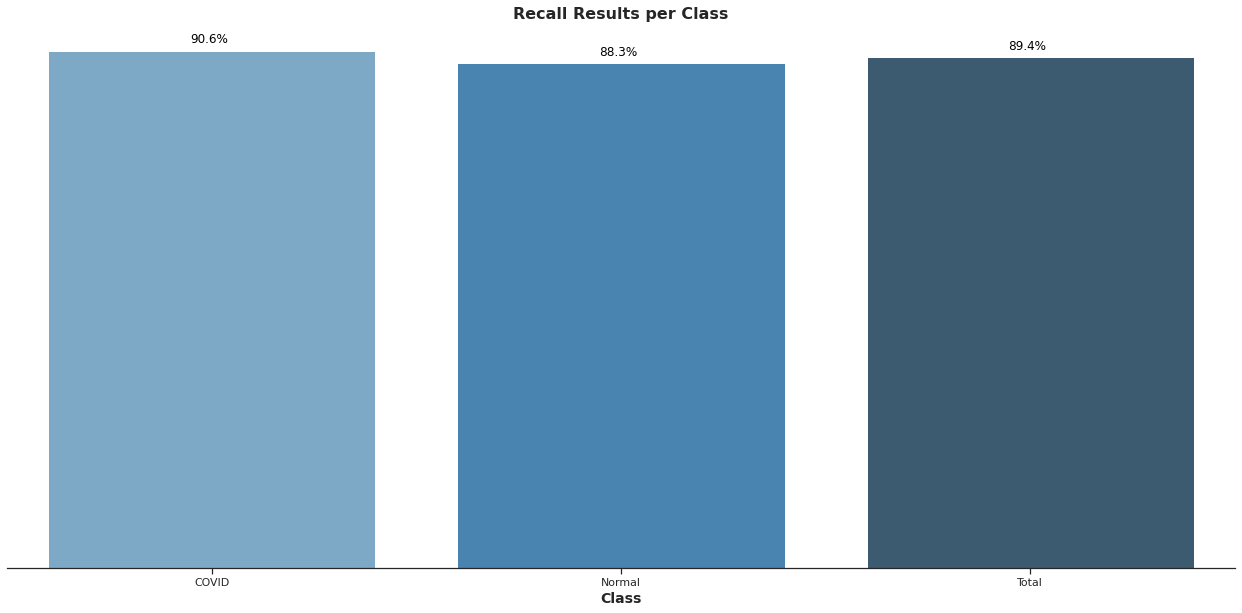

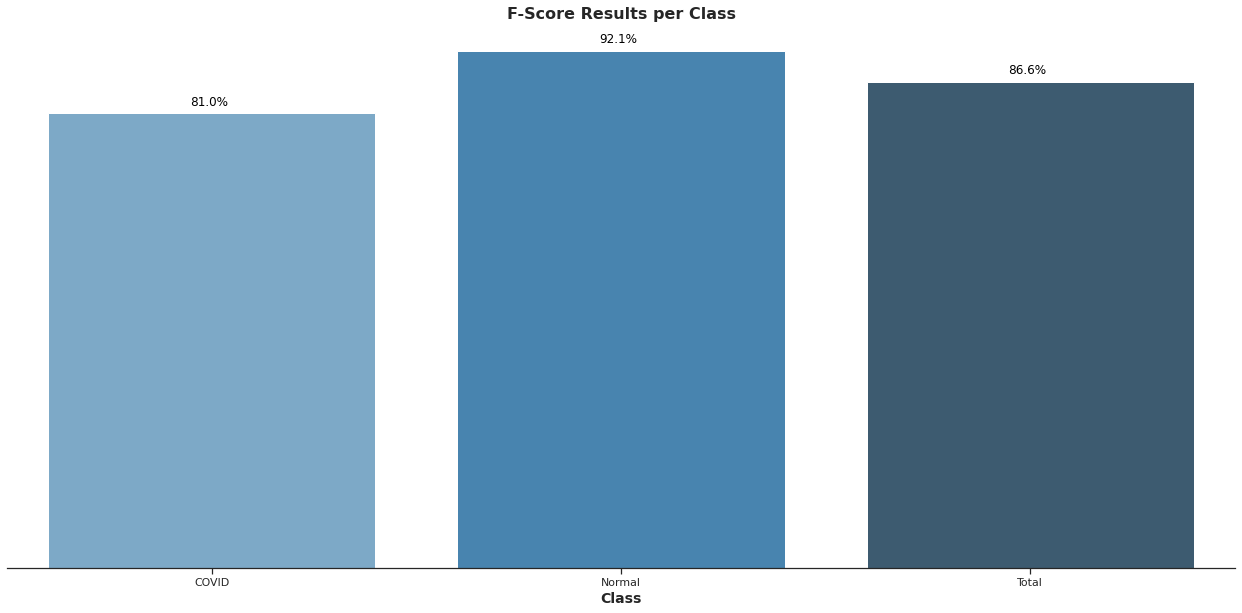

In [29]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset

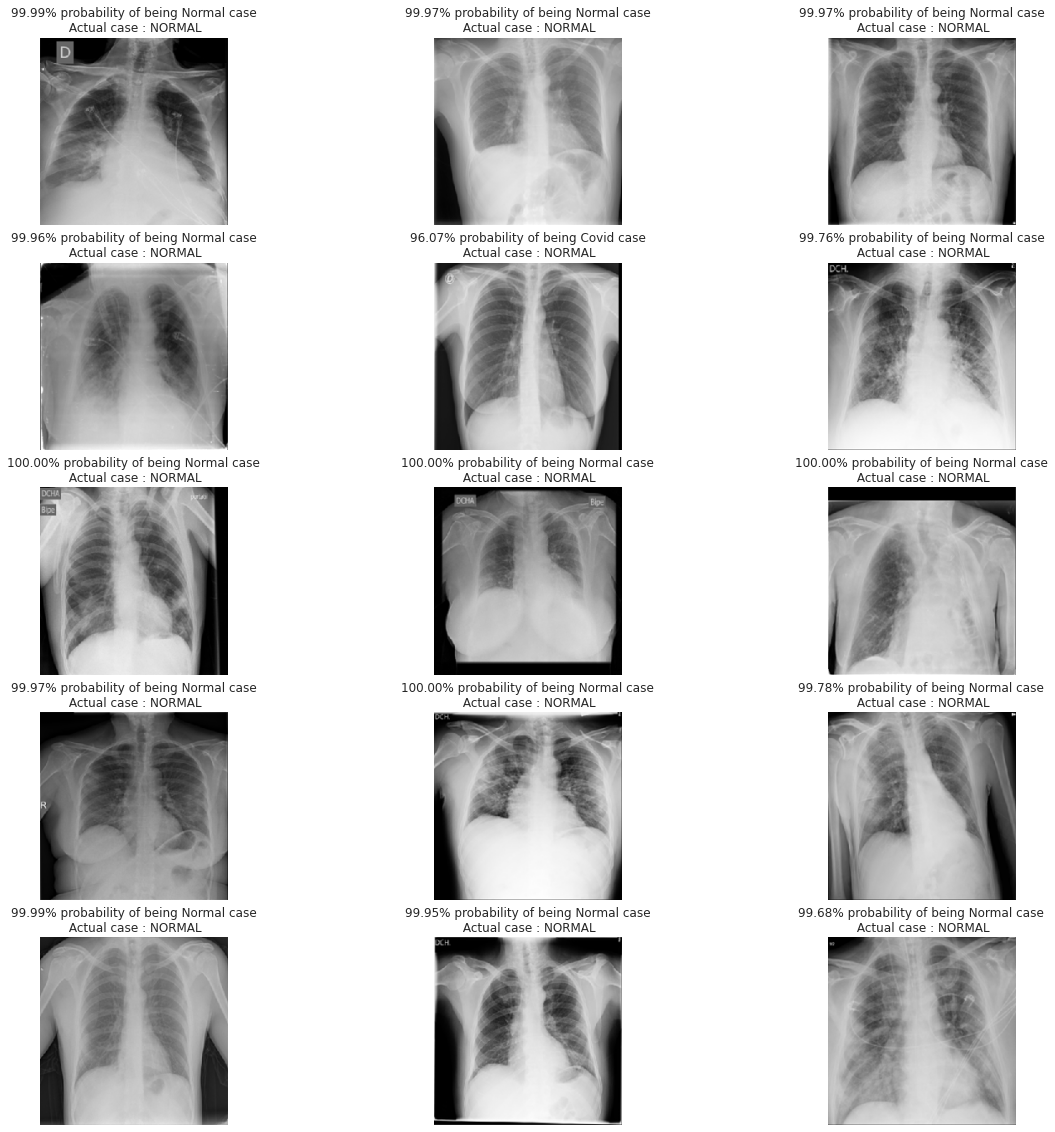

In [30]:
dic = {0:'NORMAL', 1:'COVID'}
plt.figure(figsize=(20,20))
for i in range(0+224, 15+224):
  plt.subplot(5,3, (i-224)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Covid case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

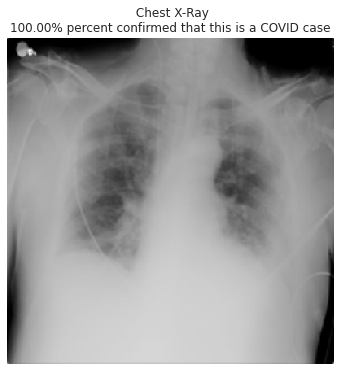

In [31]:
# Testing with random Chest X-Ray
img_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1.png'
from tensorflow.keras.preprocessing import image
img = image.load_img(img_path, target_size=(224,224))

# Preprocessing the image
pp_img = image.img_to_array(img)
pp_img = pp_img/255
pp_img = np.expand_dims(pp_img, axis=0)

#predict
preds= model.predict(pp_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(preds[0][0]))
    
else: 
    out = ('{:.2%} percent confirmed that this is a COVID case'.format(1-preds[0][0]))
    

plt.title(" Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_img))
plt.show()

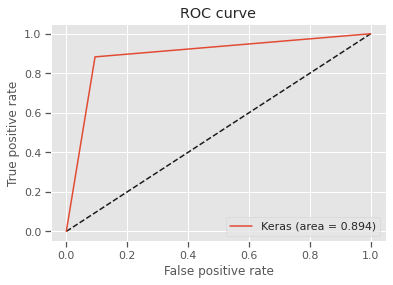

In [33]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test.classes, predictions)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()